# Read from log

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import sys, os
sys.path.append('/home/tree/ecat_dev/motor_calibration')
sys.path.append('/home/tree/ecat_dev/motor_calibration/friction_calibration_tool/utils_module')
import process_friction
import freq_domain

In [9]:
log_file = '/logs/ALE01-ELE01-H4236-20201027134725-friction_calib.log'

In [10]:
data_dict = {
        'time' :      [float(x.split('\t')[ 0]) / 1000000000 for x in open(log_file).readlines()],
        'trj_cnt' :   [  int(x.split('\t')[ 1]) for x in open(log_file).readlines()],
        'log_cnt' :   [  int(x.split('\t')[ 2]) for x in open(log_file).readlines()],
        'loop_cnt' :  [  int(x.split('\t')[ 3]) for x in open(log_file).readlines()],
        'pos_abs' :   [float(x.split('\t')[ 4]) for x in open(log_file).readlines()],
        'link_pos' :  [float(x.split('\t')[ 5]) for x in open(log_file).readlines()],
        'motor_pos' : [float(x.split('\t')[ 6]) for x in open(log_file).readlines()],
        'link_vel' :  [float(x.split('\t')[ 7]) / 1000 for x in open(log_file).readlines()],
        'motor_vel' : [float(x.split('\t')[ 8]) / 1000 for x in open(log_file).readlines()],
        'torque' :    [float(x.split('\t')[ 9]) for x in open(log_file).readlines()],
        'aux':        [float(x.split('\t')[10]) for x in open(log_file).readlines()]
    }

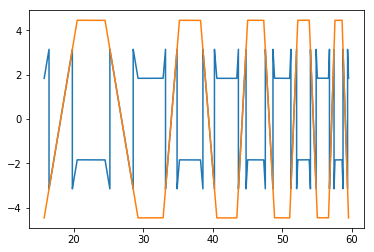

In [11]:
plt.plot(data_dict['time'], data_dict['motor_pos'])
plt.plot(data_dict['time'], data_dict['pos_abs'])

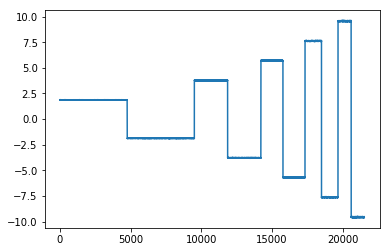

In [12]:
plt.plot( data_dict['motor_vel'])

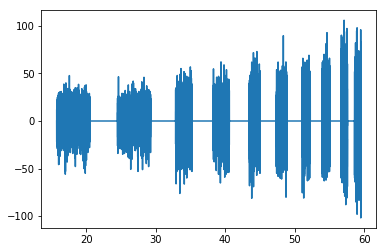

In [13]:
data_dict['motor_acc'] = [0.0]+[(data_dict['motor_vel'][i]-data_dict['motor_vel'][i-1])/(data_dict['time'][i]-data_dict['time'][i-1])  
    if (data_dict['loop_cnt'][i-1] == data_dict['loop_cnt'][i]) and (data_dict['loop_cnt'][i] == data_dict['loop_cnt'][i+1]) else 0.0
    for i in range(1, len(data_dict['time'])-1)] + [0.0]
plt.plot(data_dict['time'], data_dict['motor_acc'])

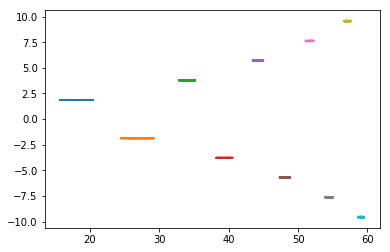

In [14]:
ids = [0] + [i for i in range(1, len(data_dict['loop_cnt'])-1) if data_dict['loop_cnt'][i] != data_dict['loop_cnt'][i-1] ] + [len(data_dict['loop_cnt'])-1]
ts   = [data_dict[     'time'][ids[i-1]:ids[i]] for i in range(1, len(ids))]
vels = [data_dict['motor_vel'][ids[i-1]:ids[i]] for i in range(1, len(ids))]
for t, v in zip(ts,vels):
    plt.plot(t,v)

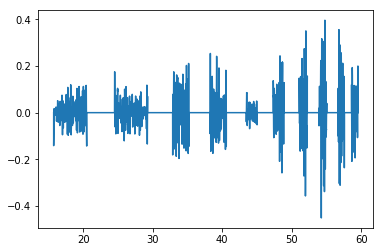

In [21]:
vels_f = [freq_domain.filtered(v, 10, 1000, method='simple') for v in vels]
accs_f = []
accs = []
for t, v, vf in zip(ts, vels, vels_f):
    accs   += [ [0.0] + [( v[i]- v[i-1])/(t[i]-t[i-1]) for i in range(1, len(t)-1)] + [0.0]]
    accs_f += [ [0.0] + [(vf[i]-vf[i-1])/(t[i]-t[i-1]) for i in range(1, len(t)-1)] + [0.0]]

motor_vel = []
for v in vels_f:
    motor_vel += list(v)

motor_acc=[]
motor_acc_f=[]
for a, af in zip(accs, accs_f):
    motor_acc += a
    motor_acc_f += af #list(freq_domain.filtered(a, 10, 1000, method='simple'))

#plt.plot(data_dict['time'], motor_acc+[0.0])
plt.plot(data_dict['time'], motor_acc_f+[0.0])

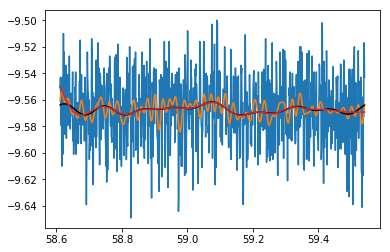

In [17]:
aux = [data_dict['aux'][ids[i-1]:ids[i]] for i in range(1, len(ids))]
aux_f = [freq_domain.filtered(v, 10, 1000, method='butter_filtfilt') for v in vels]
aux_1 = [freq_domain.filtered(v, 10, 1000, method='simple') for v in vels]
aux_2 = [freq_domain.filtered(v, 50, 1000, method='simple') for v in vels]
# for t, a, a2, f in zip(ts, vels, aux_2, aux_f):
#     plt.plot(t, a, '#1f77b4')
#     plt.plot(t, a2, '#d62728')
#     plt.plot(t, f, 'k')
plt.plot(ts[-1], vels[-1], '#1f77b4')
plt.plot(ts[-1], aux_2[-1], '#ff7f0e')
plt.plot(ts[-1], aux_1[-1], 'k')
plt.plot(ts[-1], aux_f[-1], '#d62728')

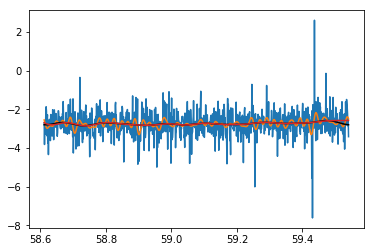

In [18]:
aux = [data_dict['aux'][ids[i-1]:ids[i]] for i in range(1, len(ids))]
aux_f = [freq_domain.filtered(v, 10, 1000, method='butter_filtfilt') for v in aux]
aux_1 = [freq_domain.filtered(v, 10, 1000, method='simple') for v in aux]
aux_2 = [freq_domain.filtered(v, 50, 1000, method='simple') for v in aux]
# for t, a, a2, f in zip(ts, vels, aux_2, aux_f):
#     plt.plot(t, a, '#1f77b4')
#     plt.plot(t, a2, '#d62728')
#     plt.plot(t, f, 'k')
plt.plot(ts[-1], aux[ -1], '#1f77b4')
plt.plot(ts[-1], aux_2[-1], '#ff7f0e')
plt.plot(ts[-1], aux_1[-1], 'k')
plt.plot(ts[-1], aux_f[-1], '#d62728')

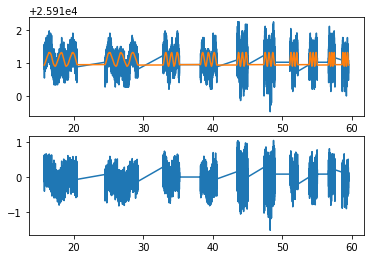

In [19]:
ripple = process_friction.get_ripple(pos=data_dict['motor_pos'])
tor_clean = [t - r for t, r in zip(data_dict['torque'], ripple)]

fig, axs = plt.subplots(2)
axs[0].plot(data_dict['time'], data_dict['torque'])
axs[0].plot(data_dict['time'], ripple)
axs[1].plot(data_dict['time'], tor_clean)

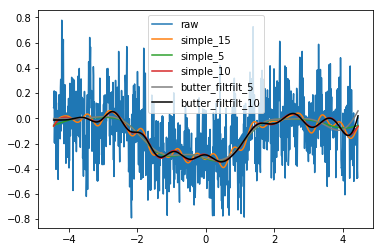

In [20]:

tor = [tor_clean[ids[i-1]:ids[i]] for i in range(1, len(ids))]
pos = [data_dict['pos_abs'][ids[i-1]:ids[i]] for i in range(1, len(ids))]
tor_f = [freq_domain.filtered(v, 10, 1000, method='butter_filtfilt') for v in tor]
tor_g = [freq_domain.filtered(v, 5, 1000, method='butter_filtfilt') for v in tor]
tor_1 = [freq_domain.filtered(v, 10, 1000, method='simple') for v in tor]
tor_2 = [freq_domain.filtered(v, 5, 1000, method='simple') for v in tor]
tor_3 = [freq_domain.filtered(v, 15, 1000, method='simple') for v in tor]
# for t, a, a2, f in zip(ts, vels, aux_2, aux_f):
#     plt.plot(t, a, '#1f77b4')
#     plt.plot(t, a2, '#d62728')
#     plt.plot(t, f, 'k')
plt.plot(pos[-3], tor[  -3], color='#1f77b4', label='raw')
plt.plot(pos[-3], tor_3[-3], color='#ff7f0e', label='simple_15')
plt.plot(pos[-3], tor_2[-3], color='#2ca02c', label='simple_5')
plt.plot(pos[-3], tor_1[-3], color='#d62728', label='simple_10')
plt.plot(pos[-3], tor_g[-3], color='#7f7f7f', label='butter_filtfilt_5')
plt.plot(pos[-3], tor_f[-3], color='k'      , label='butter_filtfilt_10')
plt.legend()